# Locally Linear Embedding (40 P)

In this assignment we will look at locally linear embedding and experiment with it on artificially generated datasets. The effects of neighbourhood size and noise on result quality will be analyzed.

Information about the algorithm, publications and demos can be found at http://www.cs.nyu.edu/~roweis/lle/

A guide for plotting can be found here: http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

We first start by importing some basic python libraries for numerical computation and plotting.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import scipy.spatial, scipy.linalg

The file `utils.py` contains several methods to generate pseudo-random three-dimensional datasets. They all have a low-dimensional manifold structure. The following code plots each dataset with default generation parameters (`N=1000` examples, and Gaussian noise of scale `0.25`).

spiral


C:\Users\huk\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


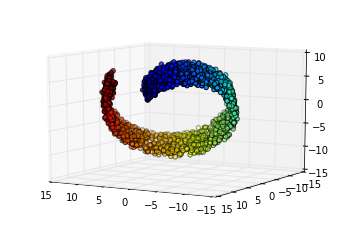

roll


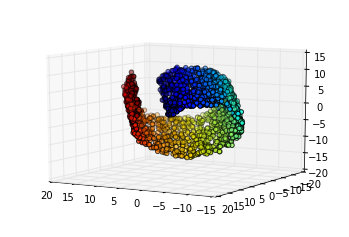

wave


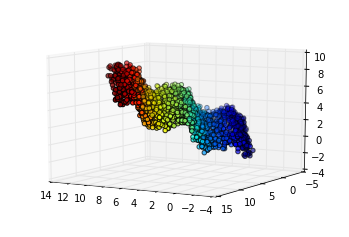

fold


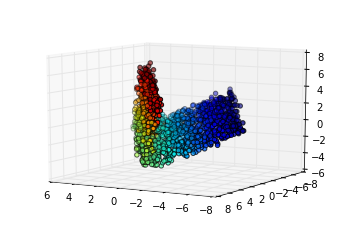

In [2]:
import utils
%matplotlib inline

for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    data,color = dataset(N=2000,noise=0.25)
    plt.figure()
    ax = plt.gca(projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
    plt.show()

## Implementing LLE (20 P)

**Implement a function `LLE(data,k)`**. The function takes as input the high-dimensinonal data the number of neighbors `k` used for reconstruction in the LLE algorithm. It returns the resulting 2D embedding (a two-dimensional array of size `Nx2`). A backbone of the implementation is given below. The implementation of LLE is described in the paper "An Introduction to LLE" linked from ISIS.

*Reminder: During computation, you need to solve the problem Cw=**1**, where **1** is a column vector (1,1,...,1). In case k>d i.e. the size of the neighbourhood is larger than the number of dimensions of the space we're mapping to, it is necessary to regularize the matrix C. You can do this by adding positive terms on the diagonal. A good starting point is 0.05.*

In [16]:
import numpy as np
import sklearn.neighbors
import scipy.sparse.linalg
import scipy.linalg

### TODO: implementation of LLE

global_W = np.array([])

def LinearOperatorForSparseComputingOfM(v):
    Mpart = (v - np.dot(global_W, v))
    return Mpart - np.dot(global_W.T, Mpart)


# Backbone implementation
def LLE(data,k): #X:NxD          Result: Nx2
    assert data.ndim==2, "Unexpected shape of argument 'data'. Given %r dimensions. Expected 2 dimensions." % data.ndim
    N, D = data.shape

    global global_W
    
    # X <- center the data 
    meanOfData = np.sum(data, axis=0) / N
    X = data - meanOfData
    
    global_W = np.zeros([N,N]) # matrix for storing reconstruction weights
    M = np.zeros([N,N]) # matrix M of which eigenvectors are computed
    
    ### 2. Iterate over all data points X to find their associated reconstruction weights
    
    # Naive nearest neighbor search via distance matrix costs ~O(N^2). 
    # Existing tree-based distance methods cost the same as comparison sorts (around ~O(DlogN) or ~O(NlogN)) 
    # Own implementations of tree-based search would be inappropriately tremendous as well as paying O(N^2) would be.
    # Thus, me made the design decision to use sklearn.neighbors.BallTree.
    tree = sklearn.neighbors.BallTree(X, leaf_size=2) #default metric is euclidean (minkowski, p=2)
    
    # A modal vector with k 1's
    one_k = np.ones(k)  # one_k: kx1
    
    for i in range(N):
        # 1. find nearest neighbors of data[i]
        eta_idx = tree.query(X[i], k = k + 1, return_distance=False)[0][1:]
        eta = X[eta_idx]
        #print "eta_idx:", eta_idx  # eta:kxD
        
        # 2. compute local covariance (with diagonal regularization), and invert it
        Cpart = np.outer(one_k,X[i]) - eta  # Cfac: kxd
        C = np.dot(Cpart, Cpart.T)
        if k > D:
            C = C + 0.05*np.trace(C)*np.eye(k)    # regularization
        
        #print "Cpart\n",Cpart
        #print "Cpart^T\n",Cpart.T
        #print "C\n",C
        
        #3. compute reconstruction weights and store them in the row of the matrix W
        #3.1 compute w
        w = np.linalg.solve(C, one_k) # The Columns and rows of C are ordered in accordance to eta_idx
        #3.1 rescale w
        scalefactor = np.dot(w.T, one_k)
        global_W[i,eta_idx] = w/scalefactor
        #print "solution w1...wk: ", global_W[i]
        
    ### 4. Compute the matrix M from W and compute the desired eigenvectors E of M
    #Mpart = np.eye(N) - global_W
    #M = np.dot( Mpart.T, Mpart)
    # Remark: We use sparse computing of the eigenvectors in order to avoid unnecessarily tremendous computation
    
    ##Sparse Method 1 - not working, uses the function obove 
    #LinOp = scipy.sparse.linalg.LinearOperator((N,N), LinearOperatorForSparseComputingOfM)
    #eig_vals, eig_vecs = scipy.sparse.linalg.eigs(LinOp, 3, which='SR', tol=.1) #get the last 3 eigenvectors
    
    ##Sparse Method 2 - blows up M tremendously, but it works for the staged example below
    Mpart = np.eye(N)-global_W
    M = np.dot(Mpart.T, Mpart)
    #eig_vals, eig_vecs = scipy.sparse.linalg.eigs(M, 3, which='SR', tol=.1) 
    
    eig_vals, eig_vecs = scipy.linalg.eig(M)
    
    #sort the eigenvectors and delete the very first one whoose components are all equal.
    eig_vecs = eig_vecs.T
    eig_vals, eig_vecs = zip(*sorted(zip(eig_vals, eig_vecs), reverse=False))
    
    
    #print "Eigenvalues: \n", eig_vals, "\nEigenvectors:\n", eig_vecs
    
    
    return np.array(eig_vecs[1:3]).T
    

LLE(np.array([[1,2,-3],[4,5,6],[7,-8,9],[-5,6,7],[5,6,9]]),2) # 6x3 data


array([[-0.16773153, -0.61146384],
       [ 0.10443873, -0.02509656],
       [ 0.20198766,  0.74013145],
       [-0.74408498,  0.13837768],
       [ 0.60539013, -0.24194874]])

In [ ]:
import numpy as np
import scipy 
M = np.array([[0,2,-1],[2,-1,1],[2,-1,3]])
v = np.array([0,1,0])
print "eig:\n",np.linalg.eig(M)[0], "\n", np.linalg.eig(M)[1]
def fun(v):
    #M = np.array([[1,0,0],[0,2,0],[0,0,3]])
    #global global_W # NxX
    #Mpart = (v - np.dot(global_W, v))
    #return Mpart - np.dot(global_W.T, Mpart)
    print "dor:", np.dot( M ,v), " v:", v
    return np.dot( M ,v)
LinOp = scipy.sparse.linalg.LinearOperator(M.shape, matvec=fun)
Evals, Evecs = scipy.sparse.linalg.eigs(LinOp, 1, which='SR', tol=.01) #get the last 3 eigenvectors
print "Eigenvalues: \n", Evals, "\nEigenvectors:\n", Evecs


**Test your implementation by running the code below.** It plots the original data (projected on the first two dimensions), and below, the two-dimensional embedding. A correct implementation produces a two-dimensional dataset where the manifold is unfolded, and where nearby points in the embedding are also neighbors in the manifold, in particular, neighboring points in the plot should have similar color.

1000


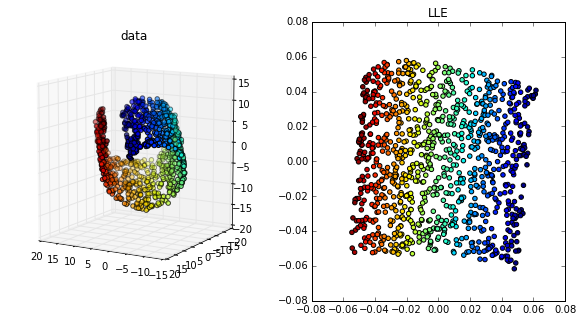

In [4]:
import utils
%matplotlib inline
data,color = utils.roll()
print len(data)
embedding = LLE(data,k=20) 
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.view_init(elev=10., azim=120)
ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
ax.set_title('data')

ax = fig.add_subplot(1,2,2)
ax.scatter(embedding[:,0],embedding[:,1],c=color)
ax.set_title('LLE')

## Experiments (20 P)

The function `compare(embed,dataset)`takes as input an embedding function and a dataset and plots the resulting embeddings for various choices of the parameter `k`, in particular, `k=5,20,80`.

In [ ]:
def compare(embed, dataset):
    cols = 4
    
    fig = plt.figure(figsize=(3*cols, 3))
    
    # Plot the data
    data, color = dataset()
    ax = fig.add_subplot(1, cols, 1,projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
    
    ax.set_title('data')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_zticks([], [])

    # Plot embeddings with various parameters K
    for i, k in enumerate([5,20,80]):
        ax = fig.add_subplot(1, cols, 2+i)

        z = embed(data,k=k)

        ax.scatter(z[:,0], z[:,1], c=color)
        ax.set_title('LLE, k=%d'%k)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
    plt.tight_layout()
    plt.show()

### Datasets and optimal parameter `k`

The code below tests the LLE embedding algorithm on each dataset: spiral, roll, wave, and fold. **Explain** what is a good parameter `k` of the LLE algorithm, and how this parameter relates to the various properties of the dataset.

**[TODO: WRITE YOUR ANSWER HERE]**

In [ ]:
for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    compare(LLE,dataset)

### LLE and the effect of noise

The code below tests LLE on the spiral dataset with three different levels of noise. **Describe** how the noise affects the embedding.

**[TODO: WRITE YOUR ANSWER HERE]**

In [ ]:
for noise in [0.1,0.3,1.0]:
    print('noise=%.3f'%noise)
    dataset = lambda: utils.spiral(noise=noise)
    compare(LLE,dataset)

### Discussion

* When applying LLE to a 200-dimensional dataset which can't be visualized, how would you assess whether the found embedding is good? Discuss how you would do it or argue why it can't be done.

 **[TODO: WRITE YOUR ANSWER HERE]**


* Could utilizing this technique in conjuction with a classifier improve its performance? Which classifiers, if any, would benefit the most?

 **[TODO: WRITE YOUR ANSWER HERE]**